In [1]:
import os
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc
import fiona
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe

import pyproj
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

import read_data, concatenation, radar

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
roads = gpd.read_file('../data/allroads_miv14a.shp')
wash_zips = [48105,48104,48106,48109,48108,49236,48190,48189,48115,48191,
49240,48198,48118,48197,48130,48137,48158,48160,48175,48176,48103,
]

wayne_zips = [
48277,48101,48111,48112,48120,48122,48124,
48126,48125,48128,48127,48134,48135,48138,48141,48150,48146,48152,48154,48164,
48167,48168,48173,48170,48174,48180,48184,48183,48186,48185,48188,48187,48192,
48195,48193,48202,48201,48204,48203,48206,48205,48208,48207,48210,48209,48212,
48211,48214,48213,48216,48215,48218,48217,48219,48222,48221,48224,48223,48226,
48225,48228,48227,48230,48229,48234,48236,48235,48238,48240,48239,48266,48265,
]
zips = wash_zips + wayne_zips
roads = roads[(roads['ZIPL'].isin(zips)) | (roads['ZIPR'].isin(zips))]
roads = roads.to_crs(epsg=4326)

In [3]:
# Load updated product and reference radar product
f1 = nc.Dataset('../data/product_20140811_agg.nc')
f0 = nc.Dataset('../data/product_20140811_nocars.nc')
extent = (f1.variables['lon'][:].min(), f1.variables['lon'][:].max(),
          f1.variables['lat'][:].min(), f1.variables['lat'][:].max())
norm = f0.variables['normmax'][0]

In [4]:
# Read radar data
date = '20140811'
p_radar = read_data.radar_to_panel('../data/data_{0}.nc'.format(date),
                                   'radar', dim_map={'lat' : 'latitude', 'lon' : 'longitude', 'time' : 'time'},
                                   time_unit='ns')

In [5]:
# Read vehicle data
veh = pd.read_csv('../data/20140811_vehicle_filtered.csv', header=None)
veh.columns = ['Device', 'Trip', 'Latitude', 'Longitude', 'Wiper', 'Radar', 'Step', 'y', 'x']
veh['Time'] = veh['Step'].map(pd.Series(p_radar.axes[0]))
veh.set_index('Time', inplace=True)

In [6]:
# Get times
alltimes = p_radar.axes[0]
times_of_interest = ['2014-08-11 20:01:27', '2014-08-11 17:57:12', '2014-08-11 20:07:16', '2014-08-11 20:18:54', 
                     '2014-08-11 21:11:17', '2014-08-11 22:38:33', '2014-08-11 20:53:51']

In [7]:
def add_osgb_scalebar(ax, at_x=(0.1, 0.4), at_y=(0.05, 0.075), max_stripes=5, zorder=0):
    """
    Add a scalebar to a GeoAxes of type cartopy.crs.OSGB (only).

    Args:
    * at_x : (float, float)
        target axes X coordinates (0..1) of box (= left, right)
    * at_y : (float, float)
        axes Y coordinates (0..1) of box (= lower, upper)
    * max_stripes
        typical/maximum number of black+white regions
    """
    # ensure axis is an OSGB map (meaning coords are just metres)
    # assert isinstance(ax.projection, ccrs.OSGB)
    # fetch axes coordinate mins+maxes
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    # set target rectangle in-visible-area (aka 'Axes') coordinates
    ax0, ax1 = at_x
    ay0, ay1 = at_y
    # choose exact X points as sensible grid ticks with Axis 'ticker' helper
    x_targets = [x0 + ax * (x1 - x0) for ax in (ax0, ax1)]
    ll = mpl.ticker.MaxNLocator(nbins=max_stripes, steps=[1,2,4,5,10])
    x_vals = ll.tick_values(*x_targets)
    # grab min+max for limits
    xl0, xl1 = x_vals[0], x_vals[-1]
    # calculate Axes Y coordinates of box top+bottom
    yl0, yl1 = [y0 + ay * (y1 - y0) for ay in [ay0, ay1]]
    # calculate Axes Y distance of ticks + label margins
    y_margin = (yl1-yl0)*0.25

    # fill black/white 'stripes' and draw their boundaries
    fill_colors = ['black', 'white']
    i_color = 0
    for xi0, xi1 in zip(x_vals[:-1],x_vals[1:]):
        # fill region
        ax.fill((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 fill_colors[i_color], zorder=zorder)
        # draw boundary
        ax.plot((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 'black', zorder=zorder)
        i_color = 1 - i_color

    # add short tick lines
    for x in x_vals:
        ax.plot((x, x), (yl0, yl0-y_margin), 'black', zorder=zorder)

    # add a scale legend 'Km'
    font_props = mfonts.FontProperties(size='medium')
    ax.text(
        0.5 * (xl0 + xl1),
        yl1 + y_margin,
        'km',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontproperties=font_props, zorder=zorder, size=12)

    # add numeric labels
    for x in x_vals:
        ax.text(x,
                 yl0 - 2 * y_margin,
                 '{:g}'.format((x - xl0) * 0.001),
                 verticalalignment='top',
                 horizontalalignment='center',
                 fontproperties=font_props, zorder=zorder, size=12)
        
    patches = []
    framelx = xl0 - (0.15)*(xl1 - xl0)/2
    framely = yl0 - (3)*(yl1 - yl0)/2
    framewidth = 1.15*(xl1 - xl0)
    frameheight = 4.5*(yl1 - yl0)
    fancybox = mpatches.FancyBboxPatch(
        (framelx, framely), framewidth, frameheight,
        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
    patches.append(fancybox)
    collection = PatchCollection(patches, color='white', alpha=0.5, zorder=zorder-1)
    ax.add_collection(collection)

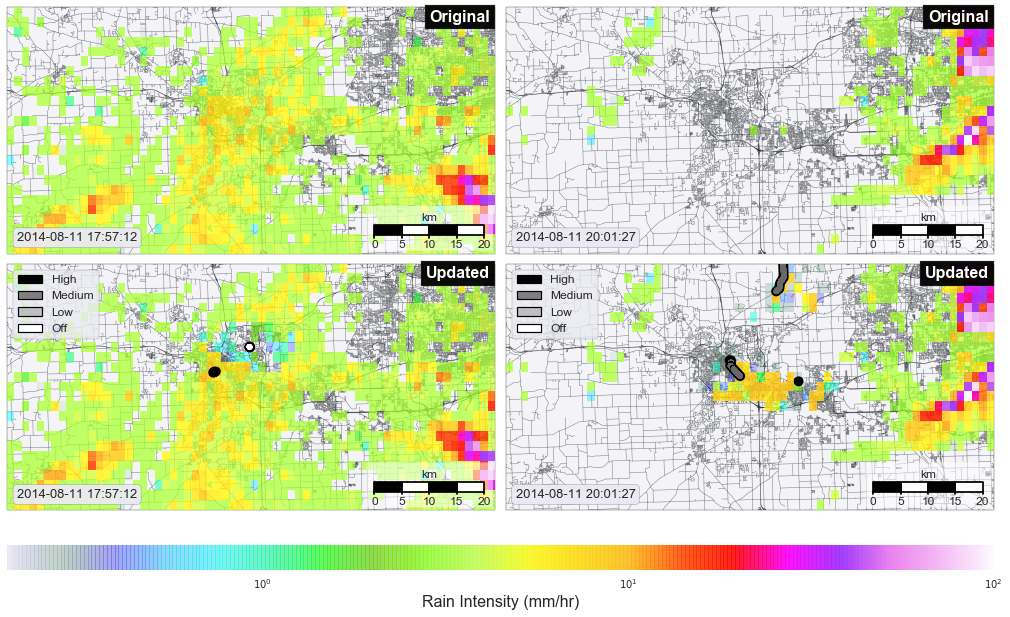

In [8]:
tiles = cimgt.StamenTerrain()
t_roads = roads.to_crs(tiles.crs.proj4_params)
veh_mut = veh.copy()

p0 = pyproj.Proj('+init=epsg:4326')
p1 = pyproj.Proj(tiles.crs.proj4_init)

fig, ax = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection=tiles.crs))

xbounds = (extent[0], extent[1])
ybounds = (extent[2], extent[3])

xbounds, ybounds = pyproj.transform(p0, p1, xbounds, ybounds)
t_extent = (xbounds[0], xbounds[1], ybounds[0], ybounds[1])

dx = xbounds[1] - xbounds[0]
dy = ybounds[1] - ybounds[0]

cmap = cm.gist_ncar
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.log10(np.linspace(1, 10, cmap.N))
my_cmap = ListedColormap(my_cmap)
vmin = 0
vmax = 3*25.4

red_patch = mpatches.Patch(facecolor='k', label='High', linewidth=1.2, edgecolor='k')
yellow_patch = mpatches.Patch(facecolor='0.5', label='Medium', linewidth=1.2, edgecolor='k')
cyan_patch = mpatches.Patch(facecolor='0.75', label='Low', linewidth=1.2, edgecolor='k')
blue_patch = mpatches.Patch(facecolor='1.0', label='Off', linewidth=1.2, edgecolor='k')
leg0 = ax[1, 0].legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
          frameon=True, fontsize=12, loc=2)
leg0.get_frame().set_edgecolor('0.4')
leg0 = ax[1, 1].legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
          frameon=True, fontsize=12, loc=2)
leg0.get_frame().set_edgecolor('0.4')

for i, t in enumerate([times_of_interest[1], times_of_interest[0]]):
    timeix = pd.Series(np.arange(len(alltimes)), index=alltimes).loc[t]
    imarr0 = f0.variables['combined'][:, :, timeix]
    imarr1 = f1.variables['combined'][:, :, timeix]
    sc = veh_mut[veh_mut['Step'] == timeix + 1]
    t_lon, t_lat = pyproj.transform(p0, p1, sc['Longitude'].values, sc['Latitude'].values)
    sc.loc[:, 'Longitude'] = t_lon
    sc.loc[:, 'Latitude'] = t_lat
    sc_x = sc['Longitude'].values
    sc_y = sc['Latitude'].values
    sc_c = sc['Wiper'].values
    
    t_roads.plot(ax=ax[0, i], linewidth=0.5, color='k', alpha=0.5, zorder=1)
    ax[0, i].axis([xbounds[0], xbounds[1], ybounds[0], ybounds[1]])
    im0 = ax[0, i].imshow(25.4*norm*imarr0[:, :-1], extent=t_extent, cmap=my_cmap, origin='lower',
               norm=LogNorm(vmin=2e-1, vmax=100), interpolation='nearest', zorder=3)
    text0 = ax[0, i].text(xbounds[0], ybounds[0], '', horizontalalignment='left', verticalalignment='bottom')
    ax[0, i].grid('off')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_facecolor('0.96')
    ax[0, i].set_alpha(0.6)
    
    t_roads.plot(ax=ax[1, i], linewidth=0.5, color='k', alpha=0.5, zorder=1)
    scat = ax[1, i].scatter(sc_x, sc_y, c=sc_c, cmap='Greys', vmin=0, vmax=3, s=25, zorder=5)
    for trip in sc['Trip'].unique():
        sc_t = sc[sc['Trip'] == trip]
        ax[1, i].plot(sc_t['Longitude'].values, sc_t['Latitude'].values, color='k', linewidth=10, zorder=4)

    ax[1, i].axis([xbounds[0], xbounds[1], ybounds[0], ybounds[1]])
    im0 = ax[1, i].imshow(25.4*norm*imarr1[:, :-1], extent=t_extent, cmap=my_cmap, origin='lower',
               norm=LogNorm(vmin=2e-1, vmax=100), interpolation='nearest', zorder=3)
    text0 = ax[1, i].text(xbounds[0], ybounds[0], '', horizontalalignment='left', verticalalignment='bottom')
    ax[1, i].grid('off')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_facecolor('0.96')
    ax[1, i].set_alpha(0.6)

    ax[0, i].annotate(t, xy=(xbounds[0] + 0.02*dx, ybounds[0] + 0.04*dy), horizontalalignment='left', verticalalignment='bottom',
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']
                                            )
            )

    ax[1, i].annotate(t, xy=(xbounds[0] + 0.02*dx, ybounds[0] + 0.04*dy), horizontalalignment='left', verticalalignment='bottom',
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']
                                            )
            )
        
ax[0, 0].annotate('Original', xy=(xbounds[1] - 0.01*dx, ybounds[1] - 0.01*dy), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k',
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[0, 1].annotate('Original', xy=(xbounds[1] - 0.01*dx, ybounds[1] - 0.01*dy), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[1, 0].annotate('Updated', xy=(xbounds[1] - 0.01*dx, ybounds[1] - 0.01*dy), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[1, 1].annotate('Updated', xy=(xbounds[1] - 0.01*dx, ybounds[1] - 0.01*dy), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )

add_osgb_scalebar(ax[0, 0], at_x=(0.8, 0.95), at_y=(0.075, 0.115), zorder=5, max_stripes=3)
add_osgb_scalebar(ax[0, 1], at_x=(0.8, 0.95), at_y=(0.075, 0.115), zorder=5, max_stripes=3)
add_osgb_scalebar(ax[1, 0], at_x=(0.8, 0.95), at_y=(0.075, 0.115), zorder=5, max_stripes=3)
add_osgb_scalebar(ax[1, 1], at_x=(0.8, 0.95), at_y=(0.075, 0.115), zorder=5, max_stripes=3)


plt.tight_layout()
cb = fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='horizontal', aspect=40, pad=0.05)
cb.set_label('Rain Intensity (mm/hr)', fontsize=16)
plt.savefig('../img/fig5_log.png', bbox_inches='tight')

156
175


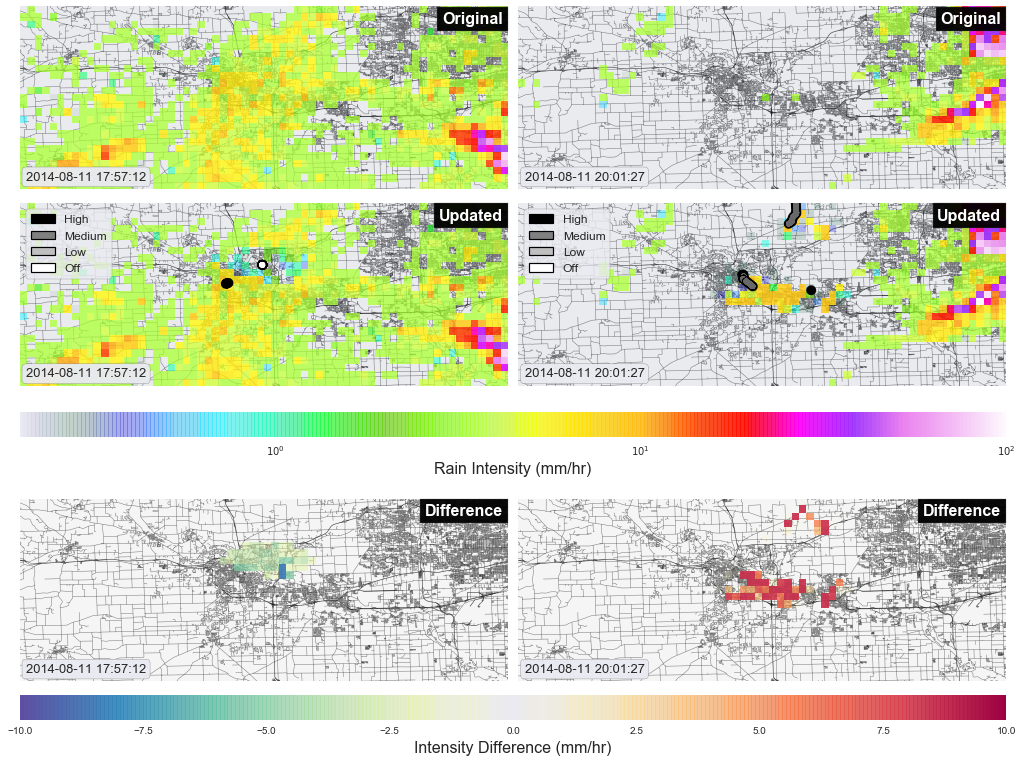

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(14, 11))

xbounds = (extent[0], extent[1])
ybounds = (extent[2], extent[3])


cmap = cm.gist_ncar
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.log10(np.linspace(1, 10, cmap.N))
my_cmap = ListedColormap(my_cmap)

diff_cmap = cm.Spectral_r
diff_cmap = diff_cmap(np.arange(cmap.N))
diff_cmap[:cmap.N//2,-1] = np.log10(np.linspace(1, 10, cmap.N//2)[::-1])
diff_cmap[cmap.N//2:,-1] = np.log10(np.linspace(1, 10, cmap.N//2))
diff_cmap = ListedColormap(diff_cmap)

vmin = 0
vmax = 2*25.4

red_patch = mpatches.Patch(facecolor='k', label='High', linewidth=1.2, edgecolor='k')
yellow_patch = mpatches.Patch(facecolor='0.5', label='Medium', linewidth=1.2, edgecolor='k')
cyan_patch = mpatches.Patch(facecolor='0.75', label='Low', linewidth=1.2, edgecolor='k')
blue_patch = mpatches.Patch(facecolor='1.0', label='Off', linewidth=1.2, edgecolor='k')
leg0 = ax[1, 0].legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
          frameon=True, fontsize=12, loc=2)
leg0.get_frame().set_edgecolor('0.4')
leg0 = ax[1, 1].legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
          frameon=True, fontsize=12, loc=2)
leg0.get_frame().set_edgecolor('0.4')

for i, t in enumerate([times_of_interest[1], times_of_interest[0]]):
    timeix = pd.Series(np.arange(len(alltimes)), index=alltimes).loc[t]
    imarr0 = f0.variables['combined'][:, :, timeix]
    imarr1 = f1.variables['combined'][:, :, timeix]
    sc = veh[veh['Step'] == timeix + 1]
    sc_x = sc['Longitude'].values
    sc_y = sc['Latitude'].values
    sc_c = sc['Wiper'].values
    
    roads.plot(ax=ax[0, i], linewidth=0.5, color='k', alpha=0.5, zorder=1)
    ax[0, i].axis([xbounds[0], xbounds[1], ybounds[0], ybounds[1]])
    im0 = ax[0, i].imshow(25.4*norm*imarr0[:, :-1], extent=extent, cmap=my_cmap, origin='lower',
               norm=LogNorm(vmin=2e-1, vmax=100), interpolation='nearest', zorder=3)
    text0 = ax[0, i].text(xbounds[0], ybounds[0], '', horizontalalignment='left', verticalalignment='bottom')
    ax[0, i].grid('off')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_facecolor('0.96')
    ax[0, i].set_alpha(0.6)
    
    roads.plot(ax=ax[1, i], linewidth=0.5, color='k', alpha=0.5, zorder=1)
    scat = ax[1, i].scatter(sc_x, sc_y, c=sc_c, cmap='Greys', vmin=0, vmax=3, s=25, zorder=5)
    for trip in sc['Trip'].unique():
        sc_t = sc[sc['Trip'] == trip]
        ax[1, i].plot(sc_t['Longitude'].values, sc_t['Latitude'].values, color='k', linewidth=10, zorder=4)

    ax[1, i].axis([xbounds[0], xbounds[1], ybounds[0], ybounds[1]])
    im0 = ax[1, i].imshow(25.4*norm*imarr1[:, :-1], extent=extent, cmap=my_cmap, origin='lower',
               norm=LogNorm(vmin=2e-1, vmax=100), interpolation='nearest', zorder=3)
    text0 = ax[1, i].text(xbounds[0], ybounds[0], '', horizontalalignment='left', verticalalignment='bottom')
    ax[1, i].grid('off')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_facecolor('0.96')
    ax[1, i].set_alpha(0.6)
    
    roads.plot(ax=ax[2, i], linewidth=0.5, color='k', alpha=0.5, zorder=1)

    ax[2, i].axis([xbounds[0], xbounds[1], ybounds[0], ybounds[1]])
    im1 = ax[2, i].imshow(np.where(np.abs(25.4*norm*imarr1[:, :-1] - 25.4*norm*imarr0[:, :-1]) > 0.01,
                                   25.4*norm*imarr1[:, :-1] - 25.4*norm*imarr0[:, :-1], np.nan),
                          extent=extent, cmap=diff_cmap, origin='lower',
               interpolation='nearest', zorder=3, vmin=-10, vmax=10)
    text0 = ax[2, i].text(xbounds[0], ybounds[0], '', horizontalalignment='left', verticalalignment='bottom')
    ax[2, i].grid('off')
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])
    ax[2, i].set_facecolor('0.96')
    ax[2, i].set_alpha(0.6)

    ax[0, i].annotate(t, xy=(xbounds[0] + 0.01, ybounds[0] + 0.01), horizontalalignment='left', verticalalignment='bottom',
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']
                                            )
            )

    ax[1, i].annotate(t, xy=(xbounds[0] + 0.01, ybounds[0] + 0.01), horizontalalignment='left', verticalalignment='bottom',
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']
                                            )
            )
    
    ax[2, i].annotate(t, xy=(xbounds[0] + 0.01, ybounds[0] + 0.01), horizontalalignment='left', verticalalignment='bottom',
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']
                                            )
            )
    
ax[0, 0].annotate('Original', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k',
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[0, 1].annotate('Original', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[1, 0].annotate('Updated', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[1, 1].annotate('Updated', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[2, 0].annotate('Difference', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )
ax[2, 1].annotate('Difference', xy=(xbounds[1] - 0.008, ybounds[1] - 0.008), horizontalalignment='right', verticalalignment='top',
            zorder=6, fontsize=16, color='w', fontweight='semibold',
                  bbox=dict(boxstyle="square", fc='k', 
                                             alpha=leg0.properties()['frame'].properties()['alpha']+0.15,
                                             linewidth=leg0.properties()['frame'].properties()['linewidth'],
                                             ec=leg0.properties()['frame'].properties()['ec']                                            
                                            )
            )


plt.tight_layout()
cb = fig.colorbar(im0, ax=ax[:2,:].ravel().tolist(), orientation='horizontal', aspect=40, pad=0.05)
cb1 = fig.colorbar(im1, ax=ax[2,:].ravel().tolist(), orientation='horizontal', aspect=40, pad=0.05)
cb.set_label('Rain Intensity (mm/hr)', fontsize=16)
cb1.set_label('Intensity Difference (mm/hr)', fontsize=16)